In [ ]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


###  flowers dataset

In [ ]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


In [ ]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [ ]:
all_image_paths[:10]

['/root/.keras/datasets/flower_photos/daisy/3410906335_37e8a24b1c_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/5955501969_e42f038a6f_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/201809908_0ef84bb351.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/15191613243_82ee8e0fe8.jpg',
 '/root/.keras/datasets/flower_photos/roses/2888138918_402096c7fb.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/9646730031_f3d5014416_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/645330051_06b192b7e1.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/6112510436_9fe06e695a_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/16169741783_deeab1a679_m.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/19508264965_d1dfb565ea_n.jpg']

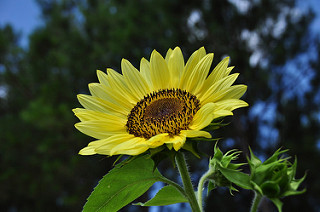

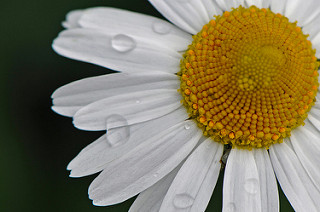

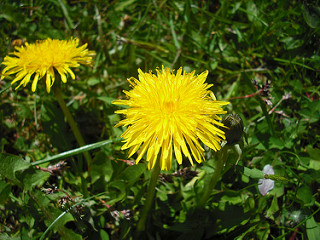

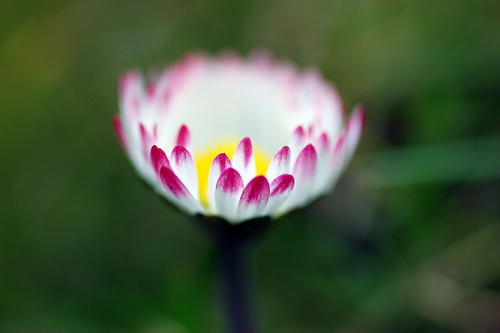

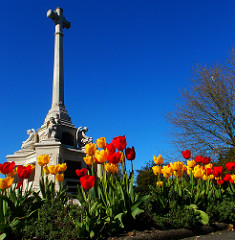

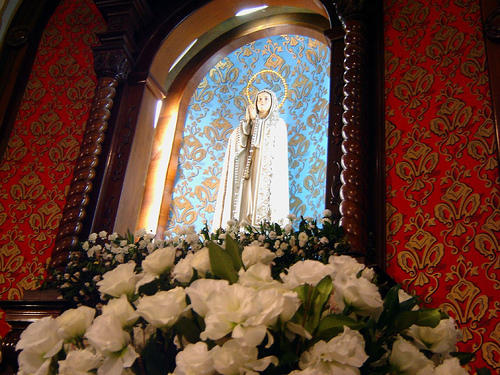

In [ ]:
for n in range(6):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [0, 3, 3, 3, 2, 1, 1, 3, 4, 3]


### Create a train/test split

In [ ]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

daisy


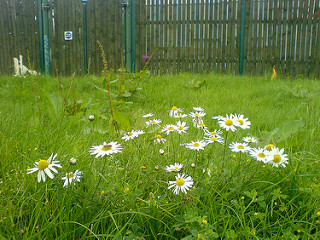


sunflowers


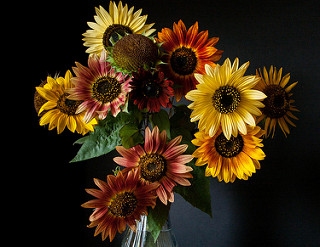


daisy


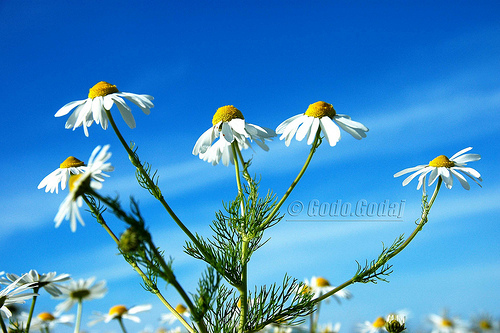

In [ ]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

In [ ]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00d\x00d\x...


In [ ]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(377, 500, 3)
<dtype: 'uint8'>


In [ ]:
IMG_SIZE=192
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

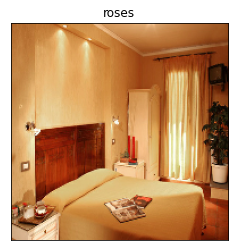

In [ ]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels


In [ ]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/3921794817_276eb4386b.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/3412874275_ca78ee024d_m.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/4590703575_6371c0a186_n.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/18760363474_a707331322_n.jpg', shape=(), dtype=string)


In [ ]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [ ]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

roses
roses
tulips
roses


In [ ]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [ ]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) roses
(192, 192, 3) roses


### Batch and shuffle


In [ ]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


### Improve performance

In [ ]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching


In [ ]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
19.74 Batches/s
631.53 Images/s
Total time: 4.3576483726501465s


In [ ]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
214.50 Batches/s
6864.10 Images/s
Total time: 0.4009263515472412s


In [ ]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

##Baseline CNN

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144400)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 722005    
Total params: 722,453
Trainable params: 722,453
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 12s 66ms/step - loss: 8.4282 - accuracy: 0.3198 - val_loss: 1.1994 - val_accuracy: 0.5196
Epoch 2/5
86/86 [==============================] - 1s 15ms/step - loss: 0.9724 - accuracy: 0.6383 - val_loss: 1.1914 - val_accuracy: 0.5349
Epoch 3/5
86/86 [==============================] - 1s 15ms/step - loss: 0.6791 - accuracy: 0.7804 - val_loss: 1.1429 - val_accuracy: 0.5621
Epoch 4/5
86/86 [==============================] - 1s 16ms/step - loss: 0.4251 - accuracy: 0.8855 - val_loss: 1.2735 - val_accuracy: 0.5436
Epoch 5/5
86/86 [==============================] - 1s 15ms/step - loss: 0.3011 - accuracy: 0.9244 - val_loss: 1.3082 - val_accuracy: 0.5327


### Make predictions on a single image


In [ ]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before
im_batch = tf.expand_dims(img,0) 

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch)
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction roses
Actual roses


In [ ]:


EPOCHS=15
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers


model = models.Sequential()
model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

#print(model.summary())

opt = optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
plt_dic = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)




Epoch 1/15
86/86 [==============================] - 3s 30ms/step - loss: 1.5584 - accuracy: 0.2637 - val_loss: 1.2426 - val_accuracy: 0.4423
Epoch 2/15
86/86 [==============================] - 2s 28ms/step - loss: 1.2037 - accuracy: 0.4675 - val_loss: 1.1737 - val_accuracy: 0.4956
Epoch 3/15
86/86 [==============================] - 2s 28ms/step - loss: 1.1496 - accuracy: 0.5039 - val_loss: 1.0985 - val_accuracy: 0.5556
Epoch 4/15
86/86 [==============================] - 2s 28ms/step - loss: 1.0713 - accuracy: 0.5642 - val_loss: 1.0981 - val_accuracy: 0.5512
Epoch 5/15
86/86 [==============================] - 2s 28ms/step - loss: 1.0414 - accuracy: 0.5898 - val_loss: 1.0463 - val_accuracy: 0.5861
Epoch 6/15
86/86 [==============================] - 2s 29ms/step - loss: 0.9795 - accuracy: 0.6096 - val_loss: 1.0244 - val_accuracy: 0.6024
Epoch 7/15
86/86 [==============================] - 2s 28ms/step - loss: 0.9519 - accuracy: 0.6313 - val_loss: 1.0134 - val_accuracy: 0.6035
Epoch 8/15
86

In [ ]:

print(plt_dic.history['accuracy'])

[0.35210755467414856, 0.4662064015865326, 0.5254360437393188, 0.5748546719551086, 0.5893895626068115, 0.604651153087616, 0.6268168687820435, 0.6464389562606812, 0.6500726938247681, 0.6700581312179565, 0.6776889562606812, 0.692223846912384, 0.7183866500854492, 0.7205668687820435, 0.7285610437393188]


In [ ]:
def plot_helper(plt_dic):
  epoch_list = list(range(EPOCHS))
  acc_list = plt_dic.history['accuracy']
  v_acc_list = plt_dic.history['val_accuracy']


  plt.plot(epoch_list, acc_list, color='green', label='train accuracy')
  plt.plot(epoch_list, v_acc_list, color='black', label='validation accuracy')
  plt.xlabel('epoch #')
  plt.ylabel('Training & Validation Acc')
  plt.legend()

  loss_list = plt_dic.history['loss']
  v_loss_list = plt_dic.history['val_loss']

  plt.figure()
  plt.plot(epoch_list, loss_list, color='green', label='train loss')
  plt.plot(epoch_list, v_loss_list, color='black', label='validation loss')
  plt.xlabel('epoch #')
  plt.ylabel('Training & Validation Loss')
  plt.legend()
  


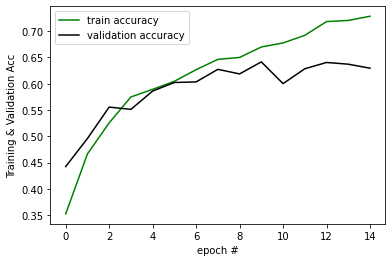

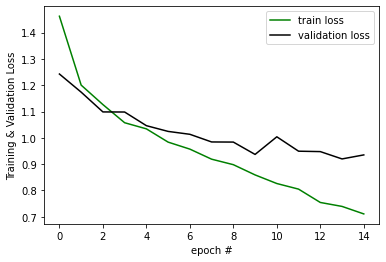

In [ ]:
plot_helper(plt_dic)

### Save  model

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
!ls -lha

total 2.1M
drwxr-xr-x 1 root root 4.0K Feb 19 16:02 .
drwxr-xr-x 1 root root 4.0K Feb 19 15:57 ..
drwxr-xr-x 1 root root 4.0K Feb 16 16:35 .config
-rw-r--r-- 1 root root 2.1M Feb 19 16:02 my_model.h5
drwxr-xr-x 1 root root 4.0K Feb 16 16:35 sample_data


In [ ]:
from google.colab import files
files.download("/content/my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


# and https://keras.io/applications/#mobilenetv2 (MobilNet V2) for its compactness->https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html

IMG_SHAPE = (192, 192, 3)

#base_model= tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model = tf.keras.applications.MobileNetV2( weights='imagenet', input_shape=IMG_SHAPE, include_top=False) 

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [ ]:

base_model.trainable = False 

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 96, 96, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [ ]:
e
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=8)

Epoch 1/8
86/86 [==============================] - 6s 41ms/step - loss: 1.0668 - accuracy: 0.5802 - val_loss: 0.5304 - val_accuracy: 0.8083
Epoch 2/8
86/86 [==============================] - 3s 32ms/step - loss: 0.4178 - accuracy: 0.8642 - val_loss: 0.4154 - val_accuracy: 0.8442
Epoch 3/8
86/86 [==============================] - 3s 32ms/step - loss: 0.3098 - accuracy: 0.9050 - val_loss: 0.3860 - val_accuracy: 0.8508
Epoch 4/8
86/86 [==============================] - 3s 32ms/step - loss: 0.2590 - accuracy: 0.9231 - val_loss: 0.3654 - val_accuracy: 0.8627
Epoch 5/8
86/86 [==============================] - 3s 32ms/step - loss: 0.2270 - accuracy: 0.9351 - val_loss: 0.3727 - val_accuracy: 0.8540
Epoch 6/8
86/86 [==============================] - 3s 32ms/step - loss: 0.1867 - accuracy: 0.9482 - val_loss: 0.3692 - val_accuracy: 0.8660
Epoch 7/8
86/86 [==============================] - 3s 32ms/step - loss: 0.1764 - accuracy: 0.9527 - val_loss: 0.3576 - val_accuracy: 0.8660
Epoch 8/8
86/86 [===

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models

IMG_SIZE=192


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
data_director= "/gdrive/My Drive/DL_data/train"

train_generator = train_datagen.flow_from_directory(
        data_director, target_size=(IMG_SIZE, IMG_SIZE), class_mode="sparse", batch_size=32 
        )

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    directory=r"/gdrive/My Drive/DL_data/test",
    batch_size=32,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="sparse", #shuffle=True, #seed=42 
    shuffle=False
)



model = models.Sequential()
model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))

model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

plot_dic = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=6
)


In [ ]:
def plot_helper(plt_dic):
  epoch_list = list(range(EPOCHS))
  acc_list = plt_dic.history['accuracy']
  v_acc_list = plt_dic.history['val_accuracy']


  plt.plot(epoch_list, acc_list, color='green', label='train accuracy')
  plt.plot(epoch_list, v_acc_list, color='black', label='validation accuracy')
  plt.xlabel('epoch #')
  plt.ylabel('Training & Validation Acc')
  plt.legend()

  loss_list = plt_dic.history['loss']
  v_loss_list = plt_dic.history['val_loss']

  plt.figure()
  plt.plot(epoch_list, loss_list, color='green', label='train loss')
  plt.plot(epoch_list, v_loss_list, color='black', label='validation loss')
  plt.xlabel('epoch #')
  plt.ylabel('Training & Validation Loss')
  plt.legend()
  

In [ ]:

EPOCHS=6
print(plot_dic)
plot_helper(plot_dic)

model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

In [ ]:
### Print a few predictions
STEP_SIZE_TEST=valid_generator.n//valid_generator.batch_size
pred=model.predict_generator(valid_generator, steps=STEP_SIZE_TEST, verbose=1)

predictions=np.argmax(pred,axis=1)
filenames=valid_generator.filenames

print(predictions)
label_names = {0: 'Alma Mater', 1: 'Butler', 2:'Low library'}

img = load_and_preprocess_image("/gdrive/My Drive/DL_data/test/" + filenames[8])
label = label_names[predictions[8]]
show(img, label)






In [ ]:
img = load_and_preprocess_image("/gdrive/My Drive/DL_data/test/" + filenames[11])
label = label_names[predictions[11]]
show(img, label)


In [ ]:
img = load_and_preprocess_image("/gdrive/My Drive/DL_data/test/" + filenames[53])
label = label_names[predictions[53]]
show(img, label)


In [ ]:
model.save("/content/my_model.h5")
from google.colab import files
files.download("/content/my_model.h5")

https://shahjaidev.github.io/